# Anomaly Detection using Isolation Forest and EBM

Summary:
* Develop an unsupervised machine learning anomaly detection model using scikit-learn's Isolation Forest algorithm
* Develop a surrogate model using the Explainable Boosting Machine algorithm for explainability
* Utilized a publicly-available credit card fraud dataset

---


## Load Required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

from sklearn.datasets import fetch_openml
from sklearn.ensemble import IsolationForest

from interpret.glassbox import ExplainableBoostingRegressor

In [2]:
X, y = fetch_openml("creditcard", version=1, as_frame=True, return_X_y=True)

total_df = pd.concat([pd.DataFrame(y), X], axis=1)
del(X, y)

total_df = total_df.rename(columns={'Class':'Fraud'})
total_df['Fraud'] = np.where(total_df.Fraud == '1', 'Y', 'N')

total_df['ID'] = total_df.index + 1
total_df = total_df[ ['ID'] + [col for col in total_df.columns if col != 'ID'] ]

total_df.head()

,ID,Fraud,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,1,N,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,2,N,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,3,N,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,4,N,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,5,N,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [3]:
total_df.isnull().all().sum()

0

In [4]:
total_df['Fraud'].value_counts()

N    284315
Y       492
Name: Fraud, dtype: int64

In [5]:
total_df.describe(include='all')

,ID,Fraud,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,284807,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,284315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,142404.000000,NaN,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.958151e-16,...,5.126845e-16,1.471982e-16,8.042109e-16,5.282450e-16,4.458267e-15,1.426896e-15,1.701640e-15,-3.671606e-16,-1.218152e-16,88.349619
std,82216.843396,NaN,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,1.000000,NaN,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,71202.500000,NaN,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,142404.000000,NaN,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,213605.500000,NaN,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000


In [6]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      284807 non-null  int64  
 1   Fraud   284807 non-null  object 
 2   V1      284807 non-null  float64
 3   V2      284807 non-null  float64
 4   V3      284807 non-null  float64
 5   V4      284807 non-null  float64
 6   V5      284807 non-null  float64
 7   V6      284807 non-null  float64
 8   V7      284807 non-null  float64
 9   V8      284807 non-null  float64
 10  V9      284807 non-null  float64
 11  V10     284807 non-null  float64
 12  V11     284807 non-null  float64
 13  V12     284807 non-null  float64
 14  V13     284807 non-null  float64
 15  V14     284807 non-null  float64
 16  V15     284807 non-null  float64
 17  V16     284807 non-null  float64
 18  V17     284807 non-null  float64
 19  V18     284807 non-null  float64
 20  V19     284807 non-null  float64
 21  V20     28

## Isolation Forest

In [7]:
X = total_df.drop(columns=['ID', 'Fraud'])

X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [8]:
ifm = IsolationForest(random_state=123)

ifm.fit(X)

IsolationForest(random_state=123)

In [9]:
ifm_output_df = pd.DataFrame({'predict': ifm.predict(X),
                              'score_samples': ifm.score_samples(X),
                              'decision_function': ifm.decision_function(X)})

ifm_output_df.head()

,predict,score_samples,decision_function
0,1,-0.371300,0.128700
1,1,-0.351518,0.148482
2,1,-0.446745,0.053255
3,1,-0.401137,0.098863
4,1,-0.378001,0.121999


In [10]:
ifm_output_df.corr()

,predict,score_samples,decision_function
predict,1.000000,0.695095,0.695095
score_samples,0.695095,1.000000,1.000000
decision_function,0.695095,1.000000,1.000000


In [11]:
ifm_output_df.groupby('predict', as_index=True).agg({'predict': ['count'],
                                                     'score_samples': ['min', 'max'],
                                                     'decision_function': ['min', 'max']})

predict score_samples           decision_function          
          count           min       max               min       max
predict                                                            
-1         9858     -0.779184 -0.500004         -0.279184 -0.000004
 1       274949     -0.499998 -0.342814          0.000002  0.157186

In [12]:
# The decision_function score is multiplied by -1 so that scores are positively associated with the likelihood of being an anomaly.

total_df = pd.concat([total_df, 
                      pd.DataFrame(ifm.decision_function(X) * -1, columns=['Anomaly Score'])],
                     axis=1)

total_df['Anomaly Decile'] = 10 - pd.qcut(total_df['Anomaly Score'], 10, labels=False)

front_vars = ['ID', 'Fraud', 'Anomaly Score', 'Anomaly Decile']

total_df = total_df[front_vars + [col for col in total_df.columns if col not in front_vars]]

del(front_vars)

total_df.head()

,ID,Fraud,Anomaly Score,Anomaly Decile,V1,V2,V3,V4,V5,V6,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,1,N,-0.128700,8,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,2,N,-0.148482,10,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,3,N,-0.053255,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,4,N,-0.098863,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,5,N,-0.121999,7,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [13]:
temp_df = total_df.copy()

temp_df['Fraud'] = np.where(temp_df.Fraud == 'Y', 1, 0)

print(temp_df.groupby('Anomaly Decile', as_index=True).agg({'Anomaly Score':['count', 'min', 'max'],
                                                            'Fraud':['mean', 'sum']}))

del(temp_df)

               Anomaly Score                         Fraud     
                       count       min       max      mean  sum
Anomaly Decile                                                 
1                      28481 -0.053707  0.279184  0.015449  440
2                      28481 -0.079202 -0.053708  0.000386   11
3                      28480 -0.092864 -0.079203  0.000421   12
4                      28480 -0.102781 -0.092865  0.000246    7
5                      28481 -0.110996 -0.102782  0.000105    3
6                      28481 -0.118194 -0.110997  0.000105    3
7                      28481 -0.125380 -0.118194  0.000246    7
8                      28480 -0.132638 -0.125380  0.000176    5
9                      28481 -0.139547 -0.132638  0.000105    3
10                     28481 -0.157186 -0.139548  0.000035    1


## Surrogate Model

In [14]:
y = total_df['Anomaly Score']
X = total_df[ifm.feature_names_in_]

X.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [15]:
ebm = ExplainableBoostingRegressor(random_state=123, interactions=0)

ebm.fit(X, y)

ExplainableBoostingRegressor(feature_names=['V1', 'V2', 'V3', 'V4', 'V5', 'V6',
                                            'V7', 'V8', 'V9', 'V10', 'V11',
                                            'V12', 'V13', 'V14', 'V15', 'V16',
                                            'V17', 'V18', 'V19', 'V20', 'V21',
                                            'V22', 'V23', 'V24', 'V25', 'V26',
                                            'V27', 'V28', 'Amount'],
                             feature_types=['continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                  

In [16]:
total_df = pd.concat([total_df,
                      pd.DataFrame(ebm.predict(X), columns=['EBM Score'])],
                     axis=1)

front_vars = ['ID', 'Fraud', 'Anomaly Score', 'Anomaly Decile', 'EBM Score']

total_df = total_df[front_vars + [col for col in total_df.columns if col not in front_vars]]

del(front_vars)

total_df.head()

,ID,Fraud,Anomaly Score,Anomaly Decile,EBM Score,V1,V2,V3,V4,V5,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,1,N,-0.128700,8,-0.127738,-1.359807,-0.072781,2.536347,1.378155,-0.338321,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,2,N,-0.148482,10,-0.142404,1.191857,0.266151,0.166480,0.448154,0.060018,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,3,N,-0.053255,1,-0.053276,-1.358354,-1.340163,1.773209,0.379780,-0.503198,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,4,N,-0.098863,4,-0.097223,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,5,N,-0.121999,7,-0.118730,-1.158233,0.877737,1.548718,0.403034,-0.407193,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [17]:
print("Model R\u00b2: {:.3f}".format(ebm.score(X, y)))

Model R²: 0.959


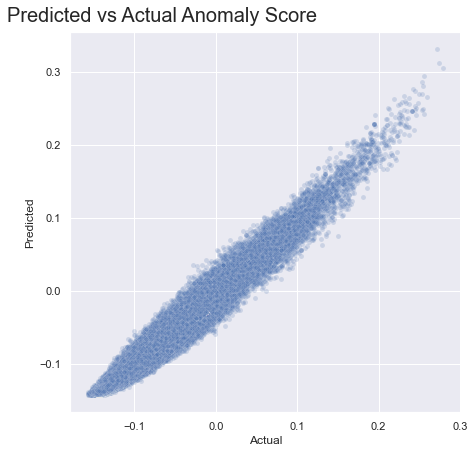

In [18]:
plot = plt.figure(figsize=(7,7))
plot = sns.scatterplot(data=total_df, x='Anomaly Score', y = 'EBM Score', alpha=0.20, s=25)
plt.figtext(0.0, 0.90, 'Predicted vs Actual Anomaly Score', fontsize=20)
plot.set(xlabel='Actual', ylabel='Predicted')
plt.show()

del(plot)

Based on the R<sup>2</sup> values and plot, it's reasonable to conclude the surrogate model can be used to explain predictions from the anomaly model.

## Explanation

### Global feature importance

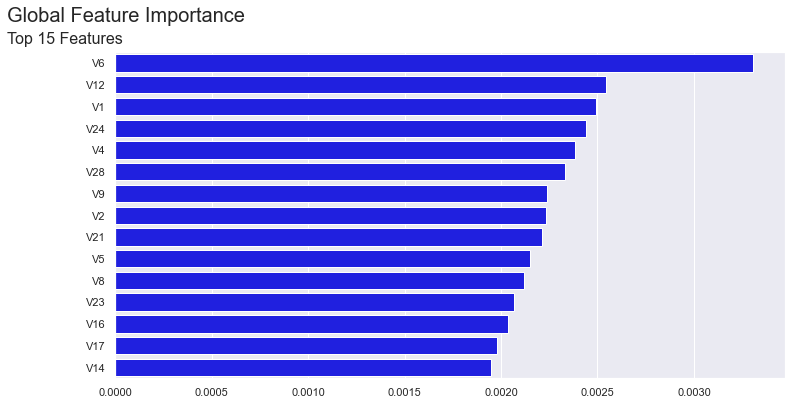

In [19]:
ebm_global = ebm.explain_global()

global_importance_df = pd.DataFrame(ebm_global.data()).sort_values(by=['scores'], ascending=False, ignore_index=True)

num_features = 15  # <-- Number of features to plot

temp_df = global_importance_df[:num_features]

plot = plt.figure(figsize=(12,6))
plot = sns.barplot(x=temp_df['scores'], y=temp_df['names'], color='blue')
plt.figtext(0.0, 0.95, 'Global Feature Importance', fontsize=20)
plt.figtext(0.0, 0.90, 'Top ' + str(num_features) + ' Features', fontsize=16)
plot.set(ylabel='', xlabel='')
plt.show()

del(ebm_global, global_importance_df, temp_df, plot)

### Local explanation

In [20]:
# Derive a description for each variable x value

data_values_df = total_df[ ['ID'] + [col for col in total_df.columns if col in ebm.feature_names] ].copy()

data_values_df['Amount'] = "$" + data_values_df['Amount'].apply("{:,.2f}".format)

other_vars = [col for col in data_values_df.columns if col not in ['ID', 'Amount']]

for var in other_vars:
    data_values_df[var] = data_values_df[var].apply("{:,.2f}".format)
    
del(other_vars)

data_values_df = data_values_df.melt(id_vars='ID', value_name='data_value', ignore_index=True).reset_index(drop=True)

data_values_df['description'] = data_values_df['variable'] + " = " + data_values_df['data_value']

data_values_df.sort_values(by='ID').head(len(ebm.feature_names)).sort_index()

,ID,variable,data_value,description
0,1,V1,-1.36,V1 = -1.36
284807,1,V2,-0.07,V2 = -0.07
569614,1,V3,2.54,V3 = 2.54
854421,1,V4,1.38,V4 = 1.38
1139228,1,V5,-0.34,V5 = -0.34
1424035,1,V6,0.46,V6 = 0.46
1708842,1,V7,0.24,V7 = 0.24
1993649,1,V8,0.10,V8 = 0.10
2278456,1,V9,0.36,V9 = 0.36
2563263,1,V10,0.09,V10 = 0.09


In [21]:
# Derive the explanation score for each variable for every record

temp_df = total_df[ebm.feature_names]

explanation_scores_df = pd.concat([total_df['ID'].reset_index(drop=True),
                                   pd.DataFrame(ebm.predict_and_contrib(temp_df)[1], columns=ebm.feature_names)],
                                  axis=1)

explanation_scores_df = explanation_scores_df.melt(id_vars='ID', value_name='explanation_score')

explanation_scores_df['abs_explanation_score'] = abs(explanation_scores_df['explanation_score'])

del(temp_df)

# Display records for the first ID
explanation_scores_df.sort_values(by='ID')[:len(ebm.feature_names)].sort_values(by='abs_explanation_score', ascending=False).sort_index()

,ID,variable,explanation_score,abs_explanation_score
0,1,V1,0.001196,0.001196
284807,1,V2,-0.001727,0.001727
569614,1,V3,-0.000164,0.000164
854421,1,V4,-0.001507,0.001507
1139228,1,V5,-0.001639,0.001639
1424035,1,V6,-0.001110,0.001110
1708842,1,V7,-0.001126,0.001126
1993649,1,V8,-0.001564,0.001564
2278456,1,V9,-0.001740,0.001740
2563263,1,V10,-0.001757,0.001757


In [22]:
# Create final dataframe to create local explanation plots

local_explanation_df = pd.merge(data_values_df, explanation_scores_df, on=['ID', 'variable'])

local_explanation_df.sort_values(by='ID')[:len(ebm.feature_names)].sort_index()

,ID,variable,data_value,description,explanation_score,abs_explanation_score
0,1,V1,-1.36,V1 = -1.36,0.001196,0.001196
284807,1,V2,-0.07,V2 = -0.07,-0.001727,0.001727
569614,1,V3,2.54,V3 = 2.54,-0.000164,0.000164
854421,1,V4,1.38,V4 = 1.38,-0.001507,0.001507
1139228,1,V5,-0.34,V5 = -0.34,-0.001639,0.001639
1424035,1,V6,0.46,V6 = 0.46,-0.001110,0.001110
1708842,1,V7,0.24,V7 = 0.24,-0.001126,0.001126
1993649,1,V8,0.10,V8 = 0.10,-0.001564,0.001564
2278456,1,V9,0.36,V9 = 0.36,-0.001740,0.001740
2563263,1,V10,0.09,V10 = 0.09,-0.001757,0.001757


In [23]:
def explain_single_prediction(ID, num_features):
    truth = total_df[total_df['ID'] == ID]['Fraud'].item()
    
    temp_df = local_explanation_df[local_explanation_df['ID'] == ID]
    temp_df = temp_df.sort_values(by='abs_explanation_score', ascending=False).head(num_features)
    temp_df['direction'] = np.where(temp_df['explanation_score'] > 0, 'positive', 'negative')
    
    plot = plt.figure(figsize=(12,6))
    plot = sns.barplot(x=temp_df['explanation_score'], y=temp_df['description'], hue=temp_df['direction'],
                       palette={"positive": "red", "negative": "green"}, dodge=False)
    plot.get_legend().remove()
    plt.figtext(0.0, 0.95, "Local Explanation for ID " + str(ID) + " (Actual Fraud = " + str(truth) + ")", fontsize=20)
    plt.figtext(0.0, 0.90, "Top " + str(num_features) + " Features", fontsize=16)
    plot.set(ylabel='', xlabel='Explanation Score')
    plt.show()

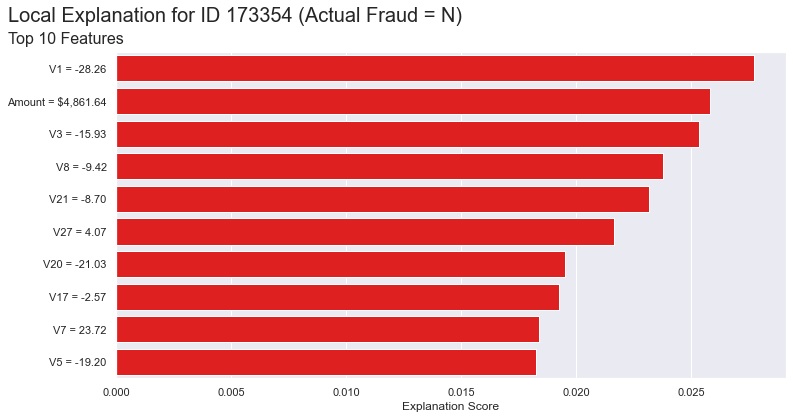

In [24]:
# Explanation for the highest anomaly score (most likely to be an anomaly)

temp_customer = total_df.sort_values(by='Anomaly Score', ascending=False).head(1)['ID'].item()

explain_single_prediction(ID = temp_customer, num_features = 10)

del(temp_customer)

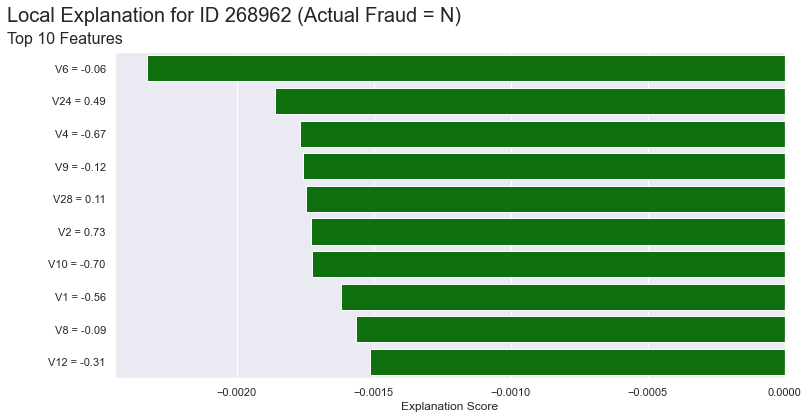

In [25]:
# Explanation for the lowest anomaly score (least likely to be an anomaly)

temp_customer = total_df.sort_values(by='Anomaly Score', ascending=True).head(1)['ID'].item()

explain_single_prediction(ID = temp_customer, num_features = 10)

del(temp_customer)

## Appendix

### Anomaly Score vs Fraud

Even though the known `Fraud` column was not considered to develop the anomaly model, a logical question is whether or not there's a relationship between `Fraud` and the derived anomaly score.

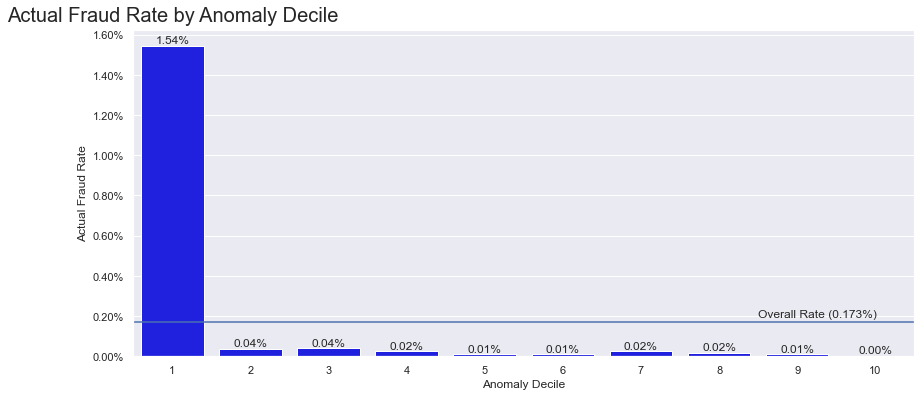

In [26]:
temp_df = total_df[['Fraud', 'Anomaly Decile']].copy()

temp_df['Fraud'] = np.where(temp_df.Fraud == 'Y', 1, 0)

temp_df = temp_df.groupby('Anomaly Decile').agg({'Fraud':['count', 'mean']}).reset_index()
temp_df.columns = ['Anomaly Decile', 'count', 'Fraud Rate']

overall_rate = (total_df['Fraud'] == 'Y').mean()*100

overall_rate_text = "Overall Rate ({:.3f}%)".format(overall_rate)

fig = plt.figure(figsize=(14,6))
fig = sns.barplot(x = temp_df['Anomaly Decile'], y = temp_df['Fraud Rate']*100, color='blue')
fig.bar_label(fig.containers[0], fmt='%.2f%%')
fig.axhline(overall_rate)
fig.text(7.5, overall_rate+0.02, overall_rate_text)
plt.figtext(0.0, 0.90, 'Actual Fraud Rate by Anomaly Decile', fontsize=20)
fig.set(ylabel='Actual Fraud Rate', xlabel = 'Anomaly Decile')
fig.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
plt.show()


In [27]:
total_df.sort_values(by='Anomaly Score', ascending=False).head(20).reset_index(drop=True)

# Fraud in this data is a very rare event. Even so, 20% of the 20 highest-scoring records are labeled as Fraud=Y

,ID,Fraud,Anomaly Score,Anomaly Decile,EBM Score,V1,V2,V3,V4,V5,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,173354,N,0.279184,1,0.305768,-28.262775,-26.551515,-15.930586,6.945207,-19.203497,...,-21.028272,-8.701341,-2.932575,-22.459170,1.771003,-3.684737,-0.106886,4.071877,-2.383081,4861.64
1,173055,N,0.273733,1,0.311521,-22.132223,-19.815536,-11.183644,4.829787,-13.128465,...,-20.522094,-8.214994,-1.969170,-18.416215,1.376122,-2.965101,0.149369,4.077221,-1.975801,4543.64
2,274772,N,0.271483,1,0.331092,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,...,-54.497720,-21.620120,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16
3,231455,N,0.259942,1,0.265422,-35.905105,-31.041362,-19.472908,9.216960,-18.863553,...,-21.964898,-2.661701,-3.016337,-19.331255,0.987774,-2.180899,-0.172480,6.228140,-2.830091,3552.96
4,154588,Y,0.255482,1,0.241801,-28.255053,21.467203,-26.871339,11.737436,-17.999630,...,10.440718,-21.453736,8.361985,4.909111,0.098328,-1.508739,0.008711,-5.407824,-0.183811,0.00
5,220091,N,0.255378,1,0.293649,-37.558067,-29.335992,-24.962322,8.413616,-35.182120,...,-28.009635,-11.263235,-1.150828,-7.800902,1.272716,1.965365,0.767817,3.248189,13.013546,5964.95
6,195219,N,0.255000,1,0.280215,-23.209602,-20.056784,-11.851649,4.811523,-16.658993,...,-25.222345,-9.019472,1.039620,2.990196,0.230236,3.214827,1.047926,-0.037677,14.046301,4248.34
7,154685,Y,0.254971,1,0.249038,-28.709229,22.057729,-27.855811,11.845013,-18.983813,...,11.059004,-22.797604,8.316275,5.466230,0.023854,-1.527145,-0.145225,-5.682338,-0.439134,0.01
8,219258,N,0.253666,1,0.248197,-29.942972,-25.831782,-16.227512,6.690679,-20.787846,...,-21.387122,-2.494699,-0.660297,-8.537816,0.400804,-0.643023,0.496903,6.267709,-2.765070,3502.11
9,206229,N,0.252929,1,0.269949,-37.054295,-35.699829,-19.880878,9.552849,-16.701866,...,-15.406594,-7.167247,-2.817629,-14.414207,1.223594,-3.129609,-0.689271,0.289897,-1.181892,1676.60


### Session Info for Reproducibility

In [28]:
import session_info

session_info.show()